In [28]:
import numpy as np
import tensorflow as tf
import pickle
from tensorboard.plugins.beholder import Beholder
import scipy
import skimage as sk
from skimage import transform
from skimage import util

# Reusing CNN Model with CIFAR-10
###### author - Kyle Hays

For this homework we will explore re-using our model from last week we classified on the CIFAR-10 dataset.
We will load the old model to make predictions on a new data set of just cat's and dog's. 
To start we will load and clean the data set.

In [7]:
with open('batches.meta', mode = 'rb') as file:\
    meta_data = pickle.load(file, encoding = 'bytes')
    
meta_data
names = [x.decode('utf-8') for x in meta_data[b'label_names']]
print(names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can see from the labels that cats are label 3 and dogs are label 5. 
When loading our batch we will pick out these labels to get a dataset of only cats and dogs.

In [8]:
num_channels = 3
img_size = 32
targets = [3,5] # 3 for cat, 5 for dog
def get_data(filename):
    import pickle
    with open(filename, mode ='rb') as file:
        data = pickle.load(file, encoding='bytes')
        batch_data_info = [x.decode('utf-8') for x in data]

        labels = data[b'labels']
        raw = data[b'data']
        data[b'batch_label']
        data[b'filenames']
        '''
        Here is where we convert the raw data into a data type suitable for tensorflow
        '''
        raw_float = np.array(raw, dtype=float) / 255.0
        images = raw_float.reshape([-1, num_channels, img_size, img_size])
        images = images.transpose([0, 2, 3, 1])
        cleansed_batch_indices = []
        for i in range(len(labels)):
            if labels[i] in targets:
                cleansed_batch_indices.append(i)
        images = images[cleansed_batch_indices]
        labels = [labels[i] for i in cleansed_batch_indices]
        for i in range(len(labels)):
            if labels[i] == 3:
                labels[i] = 0
            else:
                labels[i] = 1
                
        #print(cleansed_batch_indices)
        print('image input format: ', images.shape)
        print('image labels: ', len(labels))
        return (images, labels)


This function takes in a filename for the batch file. It loads the batch into a json dictionary which is then parsed to retrieve the labels and raw data. The raw data is sorted to find only the images of cats and dogs. The raw data is reshaped into the proper format of (num_batches, height, width, color channels) for tensorflow processing.The labels are relabeled to 0 for cats and 1 for dogs. 

In [9]:
filename1 = 'data_batch_1'
images_batch1, labels_batch1 = get_data(filename1)

filename2 = 'data_batch_2'
images_batch2, labels_batch2 = get_data(filename2)

filename3 = 'data_batch_3'
images_batch3, labels_batch3 = get_data(filename3)

filename4 = 'data_batch_4'
images_batch4, labels_batch4 = get_data(filename4)

filename5 = 'data_batch_5'
images_batch5, labels_batch5 = get_data(filename5)

filename_test = 'test_batch'
images_batch_test, labels_batch_test = get_data(filename_test)

image input format:  (1953, 32, 32, 3)
image labels:  1953
image input format:  (1983, 32, 32, 3)
image labels:  1983
image input format:  (2026, 32, 32, 3)
image labels:  2026
image input format:  (1997, 32, 32, 3)
image labels:  1997
image input format:  (2041, 32, 32, 3)
image labels:  2041
image input format:  (2000, 32, 32, 3)
image labels:  2000


After loading each batch of images we need to combine them into one large data set for batch processing during the tensorflow session. We will use numpy's vertical stack method to combine the image matricie's and use numpy's horizontal stack to combine labels. This will give us a training set of 10,000 images. This is a relatively  small data set for a Neural Network and will require data augmentation to boost the data set. 

In [10]:
images = np.vstack((images_batch1, images_batch2))
images = np.vstack((images, images_batch3))
images = np.vstack((images, images_batch4))
images = np.vstack((images, images_batch5))

labels = np.hstack((labels_batch1, labels_batch2))
labels = np.hstack((labels, labels_batch3))
labels = np.hstack((labels, labels_batch4))
labels = np.hstack((labels, labels_batch5))

In [11]:
print('training images:', images.shape)
print('training labels:', labels.shape )

training images: (10000, 32, 32, 3)
training labels: (10000,)


# Original Model
First we will run and test our original model from last week on a dataset of only cats and dogs.
We will adjust the classifier accordingly.
We will change the outputs to 2 along with the batch size to 10,000 instead of 50,000.

In [24]:
# -*- coding: utf-8 -*-
"""
Starter code for HW 13

@author: Aurelien Geron.  This code is from 
github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb
"""

height = 32
width = 32
channels = 3
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 2

weight_init = he_init = tf.keras.initializers.glorot_uniform(seed=None)
tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name ='X')
    y = tf.placeholder(tf.int32, shape=[None], name="y")

    conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                             strides=conv1_stride, padding=conv1_pad,kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
                             activation=tf.nn.leaky_relu, name="conv1")

    dropout1 = tf.layers.dropout(conv1, rate=0.2)

    conv2 = tf.layers.conv2d(dropout1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                             strides=conv2_stride, padding=conv2_pad,kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
                             activation=tf.nn.leaky_relu, name="conv2")
    

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    dropout2 = tf.layers.dropout(pool3, rate=0.3)
    pool3_flat = tf.reshape(dropout2, shape=[-1, pool3_fmaps * 8 * 8])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.leaky_relu, name="fc1", kernel_initializer = weight_init)
    fc2 = tf.layers.dense(fc1, n_fc1 , activation=tf.nn.leaky_relu, name="fc2", kernel_initializer = weight_init)
    fc3 = tf.layers.dense(fc2, n_fc1 , activation=tf.nn.leaky_relu, name="fc3", kernel_initializer = weight_init)  
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc3, n_outputs, name="output", activation=tf.nn.leaky_relu)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")    

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))  
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(10000, size=batch_size)  # not shown
    X_batch = images[indices] # not shown,
    y_batch = labels[indices].ravel() # not shown
    return X_batch, y_batch

from datetime import *
root_logdir = 'C:/Users/Kyle/tf_logs/'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
accuracy_summary = tf.summary.scalar('accuracy_train', accuracy)
accuracy_summary2 = tf.summary.scalar('accuracy_test', accuracy)
file_write = tf.summary.FileWriter(logdir, tf.get_default_graph())




In [25]:
n_epochs = 20
n_batches = 200
batch_size = 50


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)
            if iteration %10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str2 = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str3 = accuracy_summary2.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
                step = epoch *n_batches + iteration
                file_write.add_summary(summary_str, step)   
                file_write.add_summary(summary_str2, step)
                file_write.add_summary(summary_str3, step) 
                
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
        
        print(epoch, "Batch accuracy:", acc_train, "Test accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final2.ckpt")

0 Batch accuracy: 0.64 Test accuracy: 0.6575
1 Batch accuracy: 0.72 Test accuracy: 0.701
2 Batch accuracy: 0.78 Test accuracy: 0.715
3 Batch accuracy: 0.84 Test accuracy: 0.7265
4 Batch accuracy: 0.94 Test accuracy: 0.7185
5 Batch accuracy: 0.92 Test accuracy: 0.7115
6 Batch accuracy: 0.92 Test accuracy: 0.7255
7 Batch accuracy: 0.96 Test accuracy: 0.7205
8 Batch accuracy: 0.96 Test accuracy: 0.7305
9 Batch accuracy: 1.0 Test accuracy: 0.7145
10 Batch accuracy: 1.0 Test accuracy: 0.7205
11 Batch accuracy: 1.0 Test accuracy: 0.7185
12 Batch accuracy: 1.0 Test accuracy: 0.717
13 Batch accuracy: 1.0 Test accuracy: 0.733
14 Batch accuracy: 1.0 Test accuracy: 0.72
15 Batch accuracy: 1.0 Test accuracy: 0.714
16 Batch accuracy: 1.0 Test accuracy: 0.721
17 Batch accuracy: 1.0 Test accuracy: 0.713
18 Batch accuracy: 0.98 Test accuracy: 0.723
19 Batch accuracy: 1.0 Test accuracy: 0.7225


We know our data set is lacking in size, so we will boost our datset in our fetch_batch method.
I choose to perform 3 steps for data augmentation.
First I used the numpy fliplr to simply flip the image in a left-right orientation.
Next I used scipy's image rotater to rotate the images 80,180, and 270 degreese.
Finally, I applied a gaussian_gradient_magnitude filter which acts as an edge detector on the image.
With all of this combined I am able to boost the data set by a factor of 5.
This will hopefully return the dataset to its full 50,000 size improving the classifier. 

In [29]:
with tf.name_scope("fetch_batch"):
    def fetch_batch(epoch, batch_index, batch_size):
        np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
        indices1 = np.random.randint(10000, size=batch_size)  # not shown
        portions = batch_size * 5

        X_batch1 = images[indices1] # not shown,
        y_batch1 = labels[indices1].ravel() # not shown


        X_aug1 = np.fliplr(X_batch1)
        X_aug2 = scipy.ndimage.rotate(X_batch1, angle=90, order = 1, reshape = False, axes=(0,1))
        X_aug3 = scipy.ndimage.rotate(X_batch1, angle=180, order = 1, reshape = False, axes=(0,1))
        X_aug4 = scipy.ndimage.rotate(X_batch1, angle=270, order = 1, reshape = False, axes=(0,1))   
        X_aug5 = scipy.ndimage.gaussian_gradient_magnitude(X_batch1, sigma=5)

        X_batch = np.vstack((X_batch1, X_aug1))
        X_batch = np.vstack((X_batch, X_aug2))
        X_batch = np.vstack((X_batch, X_aug3))
        X_batch = np.vstack((X_batch, X_aug4))
        X_batch = np.vstack((X_batch, X_aug5))


        y_batch = np.hstack((y_batch1, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))

        return X_batch, y_batch

In [30]:
n_epochs = 20
n_batches = 200
batch_size = 50


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)
            if iteration %10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str2 = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str3 = accuracy_summary2.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
                step = epoch *n_batches + iteration
                file_write.add_summary(summary_str, step)   
                file_write.add_summary(summary_str2, step)
                file_write.add_summary(summary_str3, step) 
                
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
        
        print(epoch, "Batch accuracy:", acc_train, "Test accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final3.ckpt")

0 Batch accuracy: 0.6 Test accuracy: 0.5015
1 Batch accuracy: 0.55 Test accuracy: 0.601
2 Batch accuracy: 0.55333334 Test accuracy: 0.6315
3 Batch accuracy: 0.6166667 Test accuracy: 0.6355
4 Batch accuracy: 0.6 Test accuracy: 0.6515
5 Batch accuracy: 0.48666668 Test accuracy: 0.6715
6 Batch accuracy: 0.56333333 Test accuracy: 0.6855
7 Batch accuracy: 0.61333334 Test accuracy: 0.7035
8 Batch accuracy: 0.62 Test accuracy: 0.6985
9 Batch accuracy: 0.60333335 Test accuracy: 0.7105
10 Batch accuracy: 0.5933333 Test accuracy: 0.707
11 Batch accuracy: 0.62 Test accuracy: 0.6925
12 Batch accuracy: 0.6166667 Test accuracy: 0.699
13 Batch accuracy: 0.63 Test accuracy: 0.7095
14 Batch accuracy: 0.61 Test accuracy: 0.701
15 Batch accuracy: 0.58666664 Test accuracy: 0.694
16 Batch accuracy: 0.6533333 Test accuracy: 0.705
17 Batch accuracy: 0.60333335 Test accuracy: 0.709
18 Batch accuracy: 0.61 Test accuracy: 0.7065
19 Batch accuracy: 0.5833333 Test accuracy: 0.707


Interesting, our accuracy actually dropped with data augmentation given the same network. Next we will try to reload the network in an attempt to improve our accuracy by reusing layers, adding on layers, and optimizing the model overall.

# Building the Model from load
Next we will examine our previous model for attributes and attempt to load it. 

In [14]:
saver = tf.train.import_meta_graph("./my_model_final2.ckpt.meta")
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
reuse_vars_dict

{'conv1/kernel': <tf.Variable 'conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
 'conv1/bias': <tf.Variable 'conv1/bias:0' shape=(32,) dtype=float32_ref>,
 'conv2/kernel': <tf.Variable 'conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 'conv2/bias': <tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>,
 'fc1/kernel': <tf.Variable 'fc1/kernel:0' shape=(4096, 64) dtype=float32_ref>,
 'fc1/bias': <tf.Variable 'fc1/bias:0' shape=(64,) dtype=float32_ref>,
 'fc2/kernel': <tf.Variable 'fc2/kernel:0' shape=(64, 64) dtype=float32_ref>,
 'fc2/bias': <tf.Variable 'fc2/bias:0' shape=(64,) dtype=float32_ref>,
 'fc3/kernel': <tf.Variable 'fc3/kernel:0' shape=(64, 64) dtype=float32_ref>,
 'fc3/bias': <tf.Variable 'fc3/bias:0' shape=(64,) dtype=float32_ref>,
 'output/kernel': <tf.Variable 'output/kernel:0' shape=(64, 2) dtype=float32_ref>,
 'output/bias': <tf.Variable 'output/bias:0' shape=(2,) dtype=float32_ref>,
 'train/beta1_power': <tf.Variable 'train/beta1_power:0' shape=() d

Here we can see the avaliable operations from our previous graph. We can see that it contains almost all of our layers but is missing the X and Y input layer. Lets take a look at the list of operators in a different way.

In [15]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

inputs/X
inputs/y
conv1/kernel/Initializer/random_uniform/shape
conv1/kernel/Initializer/random_uniform/min
conv1/kernel/Initializer/random_uniform/max
conv1/kernel/Initializer/random_uniform/RandomUniform
conv1/kernel/Initializer/random_uniform/sub
conv1/kernel/Initializer/random_uniform/mul
conv1/kernel/Initializer/random_uniform
conv1/kernel
conv1/kernel/Assign
conv1/kernel/read
inputs/conv1/kernel/Regularizer/l2_regularizer/scale
inputs/conv1/kernel/Regularizer/l2_regularizer/L2Loss
inputs/conv1/kernel/Regularizer/l2_regularizer
conv1/bias/Initializer/zeros
conv1/bias
conv1/bias/Assign
conv1/bias/read
inputs/conv1/dilation_rate
inputs/conv1/Conv2D
inputs/conv1/BiasAdd
inputs/conv1/LeakyRelu/alpha
inputs/conv1/LeakyRelu/mul
inputs/conv1/LeakyRelu
inputs/dropout/Identity
conv2/kernel/Initializer/random_uniform/shape
conv2/kernel/Initializer/random_uniform/min
conv2/kernel/Initializer/random_uniform/max
conv2/kernel/Initializer/random_uniform/RandomUniform
conv2/kernel/Initializer/ran

Here we can see our X and y input layer is labeld as inputs/X and inputs/Y. These are the two inputs we will attempt to feed when we restore our session. When we restore our session we will first restore all the variables and unfreeze layers as needed. 

In [19]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

n_epochs = 1
n_batches = 5
batch_size = 150

with tf.Session() as sess:   
    saver = tf.train.import_meta_graph('my_model_final2.ckpt.meta')
    saver.restore(sess,'my_model_final2.ckpt')
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print('batch')
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)  
            print(sess.run(tf.global_variables_initializer(),feed_dict={'inputs/X:0': X_batch, 'inputs/y:0': y_batch}))
        

 

INFO:tensorflow:Restoring parameters from my_model_final2.ckpt
batch
None
batch
None
batch
None
batch
None
batch
None


After running the session loaded from the old model I am not able to achieve an output. Unfortunatley I was not able to get this to work in the given ammount of time. I was only able to get certain layers to output individually, but not as a connected network. Below is an included CNN that is an improvement on my previous model using this new dataset.

In [50]:
 # -*- coding: utf-8 -*-
"""
Starter code for HW 13

@author: Aurelien Geron.  This code is from 
github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb
"""

height = 32
width = 32
channels = 3
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 2

weight_init = he_init = tf.keras.initializers.glorot_uniform(seed=None)
tf.reset_default_graph()


To increase my accuracy I first adjusted with the architecture of my network. I choose to create a feed forward network that gets progressively thicker the farther we traverse through the network. We filter through 20, 50, and 200 filters before reaching our DNN. The stride is set to 1 to preserve as much of the image as possible while passing through multiple layers.

In [38]:
with tf.device('/device:GPU:0'):
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name ='X')
        
        y = tf.placeholder(tf.int32, shape=[None], name="y")

        conv1 = tf.layers.conv2d(X, filters=20, kernel_size=conv1_ksize,
                                 strides=conv1_stride, padding=conv1_pad,kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.5),
                                 activation=tf.nn.leaky_relu, name="conv1")

        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")

        dropout1 = tf.layers.dropout(conv1, rate=0.2)

        conv2 = tf.layers.conv2d(dropout1, filters=50, kernel_size=conv2_ksize,
                                 strides=conv2_stride, padding=conv2_pad,kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.5),
                                 activation=tf.nn.leaky_relu, name="conv2")

        pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")

        dropout3 = tf.layers.dropout(pool2, rate=0.2)
        

        conv3 = tf.layers.conv2d(dropout3, filters=200, kernel_size=conv2_ksize,
                                 strides=conv2_stride, padding=conv2_pad,kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.5),
                                 activation=tf.nn.leaky_relu, name="conv3")

        pool3_fmaps = 200

    print("conv1: ",conv1.get_shape())
    print("pool1: ",pool1.get_shape())

    print('conv2', conv2.get_shape())
    print("pool2: ",pool2.get_shape())

    print('conv3: ',conv3.get_shape())

conv1:  (?, 32, 32, 20)
pool1:  (?, 15, 15, 20)
conv2 (?, 32, 32, 50)
pool2:  (?, 15, 15, 50)
conv3:  (?, 15, 15, 200)


In [39]:
with tf.device('/device:GPU:0'):
    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")
        dropout2 = tf.layers.dropout(pool3, rate=0.3)
        print("pool3: ",pool3.get_shape())
        pool3_flat = tf.reshape(dropout2, shape=[-1, pool3_fmaps * 7 * 7])



pool3:  (?, 7, 7, 200)


In [40]:
print([-1, pool3_fmaps * 7 * 7])

[-1, 9800]


The DNN output layer is 3 layers of 800 neurons each. I found that changing the DNN output layers does not improve performance much. The best shape I found was a tunnel shape keeping the neurons equal in all layers. 

In [41]:
with tf.device('/device:GPU:0'):
    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(pool3_flat, 800, activation=tf.nn.leaky_relu, name="fc1", kernel_initializer = weight_init)
        fc2 = tf.layers.dense(fc1, 800, activation=tf.nn.leaky_relu, name="fc2", kernel_initializer = weight_init)
        fc3 = tf.layers.dense(fc2, 800, activation=tf.nn.leaky_relu, name="fc3", kernel_initializer = weight_init)

In [42]:
with tf.name_scope("output"):
    logits = tf.layers.dense(fc3, n_outputs, name="output", activation=tf.nn.leaky_relu, kernel_initializer = weight_init)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [43]:
with tf.device('/device:GPU:1'):
    learning_rate=0.001
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)
        

In [44]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [45]:
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [46]:
with tf.name_scope("fetch_batch"):
    def fetch_batch(epoch, batch_index, batch_size):
        np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
        indices1 = np.random.randint(10000, size=batch_size)  # not shown
        portions = batch_size * 5

        X_batch1 = images[indices1] # not shown,
        y_batch1 = labels[indices1].ravel() # not shown


        X_aug1 = np.fliplr(X_batch1)
        X_aug2 = scipy.ndimage.rotate(X_batch1, angle=90, order = 1, reshape = False, axes=(0,1))
        X_aug3 = scipy.ndimage.rotate(X_batch1, angle=180, order = 1, reshape = False, axes=(0,1))
        X_aug4 = scipy.ndimage.rotate(X_batch1, angle=270, order = 1, reshape = False, axes=(0,1))   
        X_aug5 = scipy.ndimage.gaussian_gradient_magnitude(X_batch1, sigma=5)

        X_batch = np.vstack((X_batch1, X_aug1))
        X_batch = np.vstack((X_batch, X_aug2))
        X_batch = np.vstack((X_batch, X_aug3))
        X_batch = np.vstack((X_batch, X_aug4))
        X_batch = np.vstack((X_batch, X_aug5))


        y_batch = np.hstack((y_batch1, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))
        y_batch = np.hstack((y_batch, y_batch1))

        return X_batch, y_batch

In [47]:
from datetime import *
root_logdir = 'C:/Users/Kyle/tf_logs/'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
accuracy_summary = tf.summary.scalar('accuracy_train', accuracy)
accuracy_summary2 = tf.summary.scalar('accuracy_test', accuracy)
file_write = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [48]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

n_epochs = 10
n_batches = 200
batch_size = 150


with tf.Session(config = config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)
            
            if iteration %10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str2 = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
                summary_str3 = accuracy_summary2.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
                step = epoch *n_batches + iteration
                file_write.add_summary(summary_str, step)   
                file_write.add_summary(summary_str2, step)
                file_write.add_summary(summary_str3, step) 
                
                
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        with tf.device('/device:GPU:1'):
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: images_batch_test, y: labels_batch_test})
        
        print(epoch, "Batch accuracy:", acc_train, "Test accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_cats_dogs_final.ckpt")

0 Batch accuracy: 0.53333336 Test accuracy: 0.6985
1 Batch accuracy: 0.60444444 Test accuracy: 0.7535
2 Batch accuracy: 0.6433333 Test accuracy: 0.755
3 Batch accuracy: 0.6577778 Test accuracy: 0.759
4 Batch accuracy: 0.6155556 Test accuracy: 0.776
5 Batch accuracy: 0.65 Test accuracy: 0.767
6 Batch accuracy: 0.61777776 Test accuracy: 0.773
7 Batch accuracy: 0.66 Test accuracy: 0.7735
8 Batch accuracy: 0.67444444 Test accuracy: 0.782
9 Batch accuracy: 0.66555554 Test accuracy: 0.778


Through data augmentation and adding of layers I was able to improve my accuracy to 78% from 70% in our previous model. From looking at our batch accuracy It looks like we wont get much more accurate than 78%. 
Next we will compare our previous model to our current model. The blue graph represents our first model while the green represents the last optimized model. 

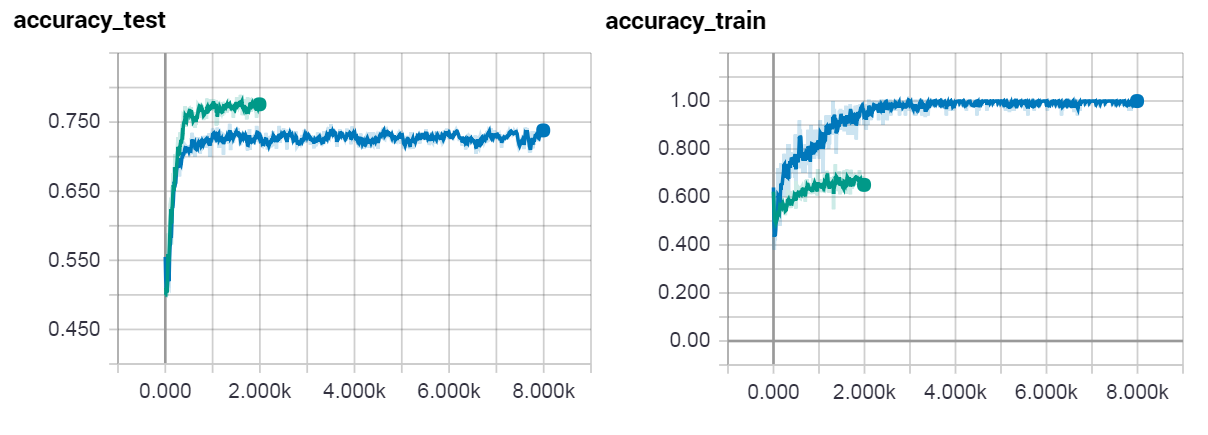

By examining the training and test accuracy graphs we can see if our model is over fitting. Our test accuracy does not improve much after 10 epochs in this model where the curve plateaus. Unlike our previous model, this current model's training accuracy has peaked at 68% compared to a peak of 90% previously. This means the new model is not over fitting the data like our previous model.

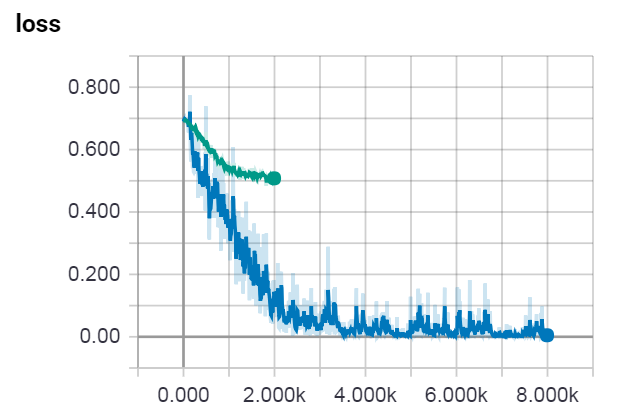

By examining our loss function we can see our optimizer is working reasonably well. We achieved a loss of 0.5 which is not great, but could definitely be improved.